# EDA

Importamos las librerias

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Ingesto los archivos

In [3]:
games = pd.read_parquet('C:/Users/dines/Desktop/PI_ML_OPS-FT/datasets/games.parquet')
items = pd.read_parquet('C:/Users/dines/Desktop/PI_ML_OPS-FT/datasets/items.parquet')
reviews = pd.read_parquet('C:/Users/dines/Desktop/PI_ML_OPS-FT/datasets/reviews.parquet')

# Matriz de correlacion generos y precio

In [4]:
genero = games.iloc[:, 4:]
precio = games['price']
matriz = pd.concat([genero, precio], axis=1)
corr = matriz.corr()
corr.style.background_gradient()

,Accounting,Action,Adventure,Animation&Modeling,AudioProduction,Casual,Design&Illustration,EarlyAccess,Education,FreetoPlay,Indie,MassivelyMultiplayer,PhotoEditing,RPG,Racing,Simulation,SoftwareTraining,Sports,Strategy,Utilities,VideoProduction,WebPublishing,price
Accounting,1.000000,-0.012541,-0.009861,0.026780,0.038370,-0.009928,0.015772,-0.003587,0.032850,-0.004307,-0.017211,-0.003124,0.042325,-0.007562,-0.003092,-0.008610,0.036010,-0.003338,-0.008818,0.039659,0.034172,0.021681,0.028791
Action,-0.012541,1.000000,0.107054,-0.063421,-0.045779,-0.169671,-0.101905,0.086701,-0.053104,0.032145,0.119743,0.062422,-0.041644,-0.048953,0.000167,-0.268034,-0.048653,-0.036585,-0.195045,-0.087651,-0.051148,-0.077952,-0.044112
Adventure,-0.009861,0.107054,1.000000,-0.050576,-0.035998,0.023342,-0.080579,0.025087,-0.041757,-0.029793,0.190596,-0.012655,-0.032746,0.104666,-0.076042,-0.194361,-0.038258,-0.086272,-0.150484,-0.068923,-0.040220,-0.061297,-0.046951
Animation&Modeling,0.026780,-0.063421,-0.050576,1.000000,0.057046,-0.048983,0.446398,-0.000316,0.433430,-0.022088,-0.087393,-0.016024,0.097390,-0.038782,-0.015857,-0.044158,0.357664,-0.017120,-0.045227,0.405131,0.298467,0.183367,0.240414
AudioProduction,0.038370,-0.045779,-0.035998,0.057046,1.000000,-0.033530,0.026886,-0.007467,0.042774,-0.015721,-0.061596,-0.011405,0.020743,-0.027604,-0.011286,-0.029978,0.159015,-0.012185,-0.032190,0.306335,0.353897,0.051826,0.109173
Casual,-0.009928,-0.169671,0.023342,-0.048983,-0.033530,1.000000,-0.081125,-0.024124,-0.042040,0.023110,0.120287,-0.049538,-0.032968,-0.156226,-0.040573,0.160251,-0.038517,0.033098,-0.061963,-0.067961,-0.040492,-0.061712,-0.138674
Design&Illustration,0.015772,-0.101905,-0.080579,0.446398,0.026886,-0.081125,1.000000,-0.011484,0.265415,-0.035191,-0.140080,-0.025530,0.363474,-0.061789,-0.025263,-0.070353,0.245010,-0.027276,-0.072056,0.428412,0.123050,0.674160,0.164052
EarlyAccess,-0.003587,0.086701,0.025087,-0.000316,-0.007467,-0.024124,-0.011484,1.000000,-0.003047,0.001764,0.136076,0.043223,-0.011913,0.044517,0.021868,0.020903,-0.005971,0.018377,0.024976,-0.001353,-0.009590,-0.020636,0.015178
Education,0.032850,-0.053104,-0.041757,0.433430,0.042774,-0.042040,0.265415,-0.003047,1.000000,-0.018236,-0.072881,-0.013230,0.057939,-0.032020,-0.013092,-0.036458,0.574403,-0.014135,-0.037341,0.380240,0.120875,0.169611,0.157044
FreetoPlay,-0.004307,0.032145,-0.029793,-0.022088,-0.015721,0.023110,-0.035191,0.001764,-0.018236,1.000000,-0.033426,0.451113,-0.014301,0.076652,-0.020137,-0.006346,-0.016708,0.110618,0.054072,-0.030100,-0.017565,-0.026770,0.037354


* La correlacion mas alta se da entre 'WebPublishing' y 'Design&Illustration' y entre 'SoftwareTraining' y 'Education'
* La correlacion ente 'price' y los diferentes generos en muy baja, siendo las mas altas = {1 : 'Animation&Modeling'}, {2 : 'VideoProduction'}, {3 : 'Design&Illustration'}, al parecer todos ellos software de desarrollo

# Top 10 generos mas frecuentes

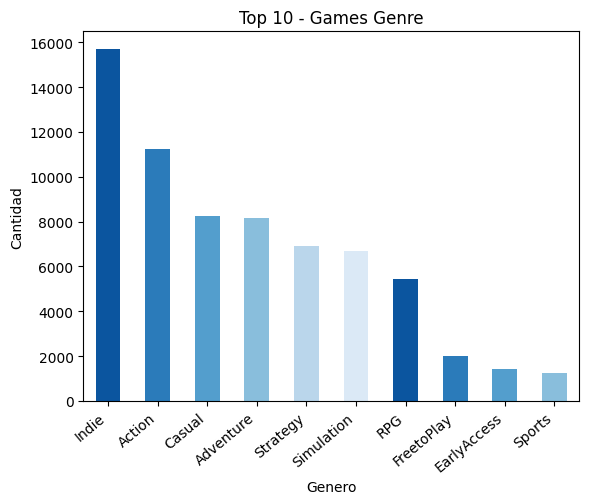

In [12]:
colors = sns.color_palette('Blues_r')
ax = matriz.iloc[:, :-1].sum().sort_values(ascending=False).head(10).plot(kind='bar', title='Top 10 - Games Genre', color=colors)
ax.set_xlabel('Genero')
ax.set_ylabel('Cantidad')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha='right')
plt.show()

# Lanzamiento por año

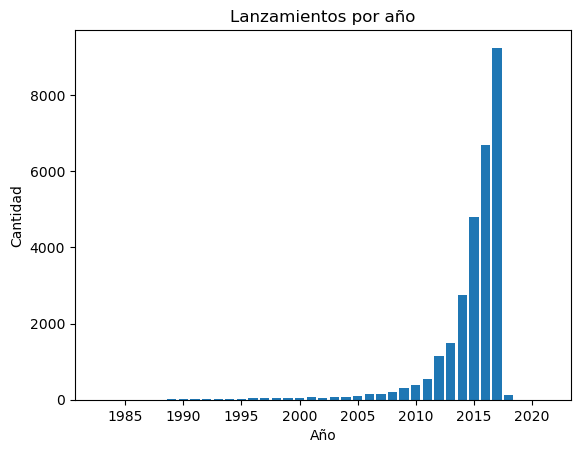

In [8]:
colors = sns.color_palette('Blues_r')
anio = games.groupby(games['release_date'].dt.year).count()
plt.bar(anio.index, anio['title'])
plt.xlabel('Año')
plt.ylabel('Cantidad')
plt.title('Lanzamientos por año')
plt.show()

* Se observa que la mayoria de los productos fueron lanzados despues del año 2015

# Top 10 juegos mas jugados

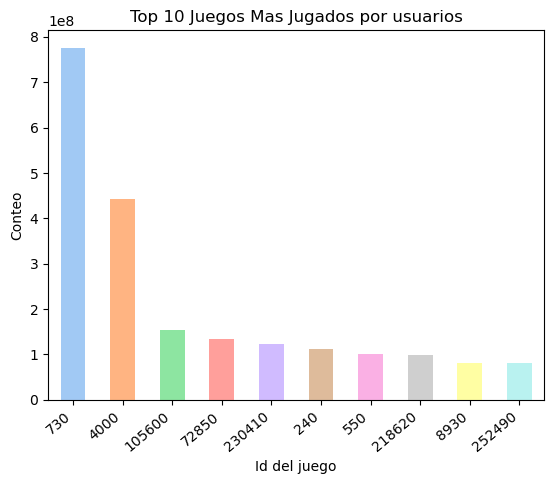

In [9]:
colors = sns.color_palette('pastel')
ax = items.groupby(["item_id"])['playtime_forever'].sum().sort_values(ascending=False)\
    .head(10)\
    .plot(kind='bar', title = 'Top 10 Juegos Mas Jugados por usuarios', color=colors)
ax.set_xlabel('Id del juego')
ax.set_ylabel('Conteo')
ax.set_xticklabels(ax.get_xticklabels(),rotation=40, ha='right')
plt.show()

# Cantidad de Reviews Recomendados vs NO Recomendados

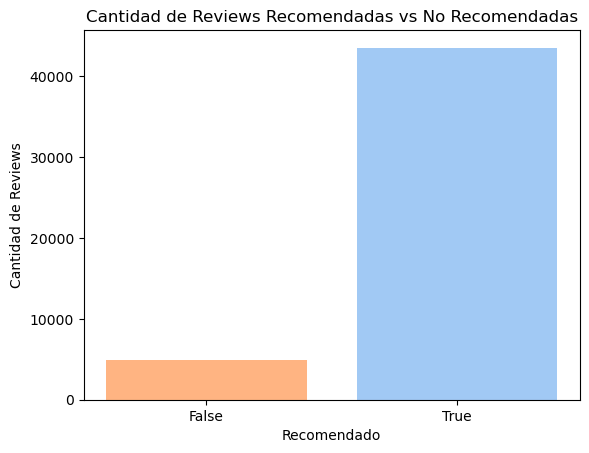

In [10]:
colors = sns.color_palette('pastel')

ax =  reviews['recommend'].value_counts()
plt.bar(ax.index, ax.values, color=colors)
plt.xlabel('Recomendado')
plt.ylabel('Cantidad de Reviews')
plt.xticks([False, True], ['False', 'True'])
plt.title('Cantidad de Reviews Recomendadas vs No Recomendadas')
plt.show()

# Analisis de sentimiento

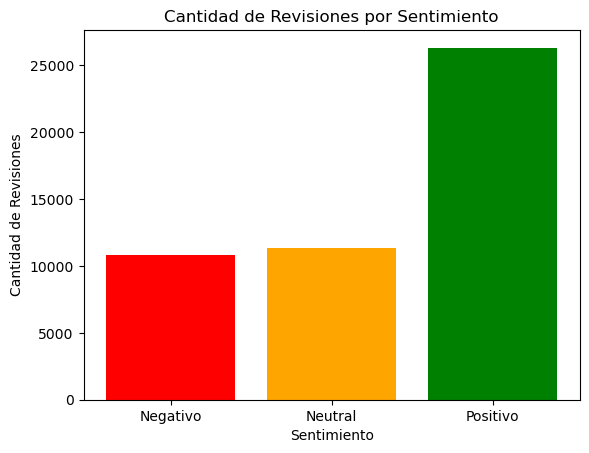

In [11]:
colors = ['green', 'orange', 'red']
df_rev_sentimiento = reviews.copy()
df_rev_sentimiento['sentimient_analysis'] = df_rev_sentimiento['sentiment_analysis']
sentimiento_counts = df_rev_sentimiento['sentiment_analysis'].value_counts()
plt.bar(sentimiento_counts.index, sentimiento_counts.values, color=colors)
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad de Revisiones')
plt.xticks([0, 1, 2], ['Negativo', 'Neutral', 'Positivo'])
plt.title('Cantidad de Revisiones por Sentimiento')
plt.show()

# Preparación del df para el modelo de recomendación

El modelo va a hacer la recomendacion teniendo en cuenta el analisis de los generos, las recomendaciones, el analisis de sentimiento y el tiempo de juego.

# games

In [12]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28658 entries, 0 to 28657
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   title                    28657 non-null  object        
 1   release_date             28658 non-null  datetime64[ns]
 2   price                    27613 non-null  float64       
 3   item_id                  28658 non-null  object        
 4   Accounting               28658 non-null  int64         
 5   Action                   28658 non-null  int64         
 6   Adventure                28658 non-null  int64         
 7   Animation&amp;Modeling   28658 non-null  int64         
 8   AudioProduction          28658 non-null  int64         
 9   Casual                   28658 non-null  int64         
 10  Design&amp;Illustration  28658 non-null  int64         
 11  EarlyAccess              28658 non-null  int64         
 12  Education                28658 n

In [13]:
# Del DF games me quedo con 'item_id' y 'title'
df_title = games[['item_id', 'title']]
df_title.head()

,item_id,title
0,761140,Lost Summoner Kitty
1,643980,Ironbound
2,670290,Real Pool 3D - Poolians
3,767400,弹炸人2222
4,772540,Battle Royale Trainer


In [14]:
# Cambio el tipo d dato para futuras consultas
df_title['item_id'] = df_title['item_id'].astype(int)

C:\Users\dines\AppData\Local\Temp\ipykernel_10604\1622096374.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_title['item_id'] = df_title['item_id'].astype(int)


# reviews

In [15]:
reviews.head()

,user_id,posted,item_id,recommend,sentiment_analysis
0,76561197970982479,2011-11-05,1250,1,2
1,76561197970982479,2011-07-15,22200,1,2
2,76561197970982479,2011-04-21,43110,1,2
3,js41637,2014-06-24,251610,1,2
4,js41637,2013-09-08,227300,1,0


In [16]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48498 entries, 0 to 58401
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   user_id             48498 non-null  object        
 1   posted              48498 non-null  datetime64[ns]
 2   item_id             48498 non-null  object        
 3   recommend           48498 non-null  int64         
 4   sentiment_analysis  48498 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 2.2+ MB


In [17]:
# Cambio el tipo de dato para poder combinar DFs
reviews['item_id'] = reviews['item_id'].astype(int)

Elimino la columna 'posted'

In [18]:
reviews.drop(['posted'], axis=1, inplace=True)

Con las columnas recommend, sentiment_analysis genero un rating

In [19]:
reviews['rating'] = reviews['recommend'] + reviews['sentiment_analysis']

Elimino las columnas 'recommend' y 'sentiment_analysis'

In [20]:
reviews.drop(['recommend', 'sentiment_analysis'], axis=1, inplace=True)

Tamaño del DF

In [21]:
reviews.shape

(48498, 3)

item_id únicos

In [22]:
item = reviews['item_id'].unique()
len(item)

2897

Calificaciones por usuario

In [23]:
users = reviews.groupby(['user_id']).count().reset_index()
users.head()

,user_id,item_id,rating
0,--000--,1,1
1,--ace--,2,2
2,--ionex--,1,1
3,-2SV-vuLB-Kg,5,5
4,-Beave-,1,1


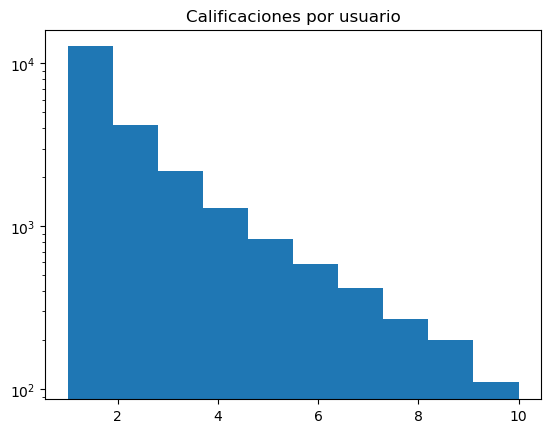

In [24]:
plt.hist(users.rating, log= True)
plt.title('Calificaciones por usuario')
plt.show()

Distribucion de calificaciones

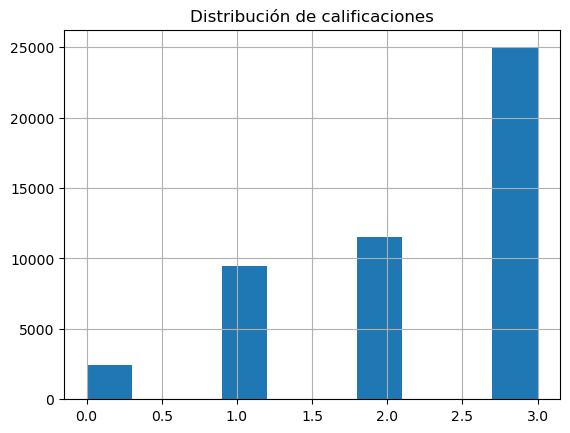

In [25]:
reviews['rating'].hist()
plt.title('Distribución de calificaciones')
plt.show()

### Item con mas calificaciones

In [26]:
game = reviews.groupby(['item_id']).count()
game.head()

,user_id,rating
item_id,,
10,50,50
20,15,15
30,4,4
40,1,1
50,4,4


In [27]:
id_max = game['user_id'].idxmax()
id_max = int(id_max)
print(df_title.loc[id_max].title)

Victoria I Complete


### Item con menos calificaciones

In [28]:
id_min = game['user_id'].idxmin()
id_min = int(id_min)
print(df_title.loc[id_min].title)

Mirt. Tales of the Cold Land. Chapter 2


### Item por popularidad

In [29]:
rev_games = reviews.groupby(['item_id']).count().reset_index()
rev_games.sort_values('user_id', ascending = False, inplace = True)
rev_games['Jugados'] = rev_games['user_id']
rev_games.drop(columns = ['user_id','rating'], inplace = True)
rev_games.head(10)

,item_id,Jugados
20,440,3401
26,730,2979
78,4000,1551
23,570,1402
982,218620,994
2079,304930,892
22,550,703
1479,252490,676
1022,221100,673
684,105600,671


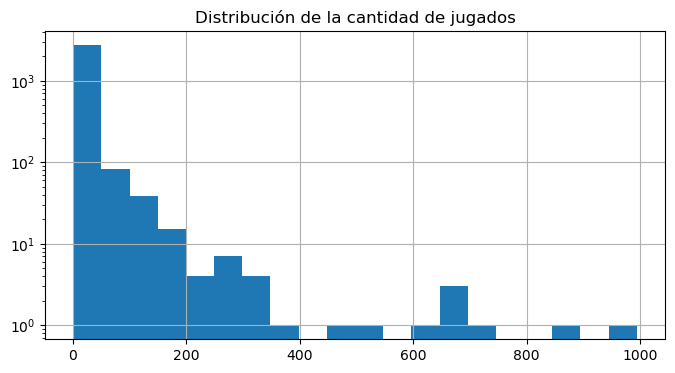

In [30]:
plt.figure(figsize = (8,4))

rev_games.Jugados[rev_games.Jugados<1000].hist(log = True, bins = 20)
plt.title('Distribución de la cantidad de jugados')

plt.show()

# Modelo de recomendación item-item

Para el modelo de recomendacion voy a analizar la columna 'genres' de cada item y recomienda en base a ello

In [32]:
model = pd.read_parquet('C:/Users/dines/Desktop/PI_ML_OPS-FT/datasets/games_1.parquet')
model.head()

,genres,title,release_date,price,item_id
0,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,2018-01-04,4.99,761140
1,"[Free to Play, Indie, RPG, Strategy]",Ironbound,2018-01-04,0.00,643980
2,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,2017-07-24,0.00,670290
3,"[Action, Adventure, Casual]",弹炸人2222,2017-12-07,0.99,767400
4,"[Action, Adventure, Simulation]",Battle Royale Trainer,2018-01-04,3.99,772540


In [33]:
# Elimino las columnas que no voy a utilizar
model.drop(['release_date', 'price'], axis=1, inplace=True)

In [34]:
# Cambio el tipo de dato a la columna 'item_id' para poder combinar model con reviews
model['item_id'] = model['item_id'].astype(int)

In [35]:
# Agrupo el DF reviews por 'item_id' y sumo los valores del rating
reviews = reviews.groupby('item_id')['rating'].sum().reset_index()

In [36]:
# Combino model y reviews
model = pd.merge(model, reviews, on='item_id' )

In [37]:
model.head()

,genres,title,item_id,rating
0,[Action],Half-Life,70,125
1,"[Action, Indie, RPG]",The Ship: Murder Party,2400,44
2,[Action],Advent Rising,3800,1
3,"[Indie, Strategy]",DEFCON,1520,14
4,"[Action, Indie, RPG]",The Ship: Single Player,2420,6


In [38]:
# Cambio el tipo de dato para poder aplicarle .lower()
model['genres'] = model['genres'].astype(str)
model['genres'] = model['genres'].apply(lambda x: x.lower())

In [39]:
# Hago un seleccion aleatoria para el modelo reducido
model_reduced = model.sample(1000)

In [194]:
# Guardoel archivo del modelo
savefile_path = 'model.parquet'
model.to_parquet(savefile_path, engine='pyarrow')

In [195]:
# Guardo el archivo del modelo reducido
savefile_path = 'model_reduced.parquet'
model_reduced.to_parquet(savefile_path, engine='pyarrow')

In [40]:
# Importo la libreria y creo el vector
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=45, stop_words="english")

#### Vectorizamos para pasar texto a un vector lo que nos permite haces comparaciones entre ellos y encontrar similitudes

In [41]:
vectors = cv.fit_transform(model_reduced['genres']).toarray()

Aplico el coseno de similitud

In [42]:
from sklearn.metrics.pairwise import cosine_similarity
similarity=cosine_similarity(vectors)

Exporto el modelo entrenado

In [43]:
import joblib
joblib.dump(similarity,'model_trained.pkl')

['model_trained.pkl']

Pruebo la función de recomendacion

In [44]:
def recommend(id_item : int):
    #como usamos un modelo preentrenado, para juegos que tuvieron reviews
    try:
        #cargamos el df dentro de la funcion 
        model = pd.read_parquet('model.parquet')
        #importamos el modelo ya entrenado
        similarity = joblib.load('model_trained.pkl')
        #buscamos el numero de indice
        idx = model[model["item_id"] == id_item].index[0]
        #y lo comparamos dentro del modelo
        distances = similarity[idx]
        #determinamos nuestras similitudes mas grandes y lo guardamos dentro de una lista   
        game = sorted(list(enumerate(distances)), reverse=True, key= lambda x:x[1])[1:6]
        #guardamos dentro de una lista con este iterador las recomendaciones
        respon = []
        for i in game:
            respon.append(model.iloc[i[0]].title)
        return {"recomendaciones": respon}
    
    
    except IndexError:    
        
        model = pd.read_parquet('model.parquet')
        
        new_game = model[model["item_id"] == id_item]
        
        df_combined = pd.concat([model,new_game])
        
        vectors = cv.fit_transform(df_combined["genres"]).toarray()
        
        similarity=cosine_similarity(vectors)
        
        idx = df_combined[df_combined["item_id"] == id_item].index[0]
        
        distances = similarity[idx]   
        
        game = sorted(list(enumerate(distances)), reverse=True, key= lambda x:x[1])[1:6]
        
        respon = []
        for i in game:
            respon.append(df_combined.iloc[i[0]].title)
        return {"recomendaciones": respon}

In [45]:
recommend(10)

{'recomendaciones': ['Advent Rising',
  'Devil May Cry® 3 Special Edition',
  'Ultimate Doom',
  'Master Levels for Doom II',
  'DOOM II']}